In [45]:
# -----------------------------------------------------------------------------
# From Numpy to Python
# Copyright (2017) Nicolas P. Rougier - BSD license
# More information at https://github.com/rougier/numpy-book
# Heavily Altered
# -----------------------------------------------------------------------------


import numpy as np
import pickle
from PIL import Image, ImageDraw



def fractal_dimension(Z, threshold=0.9):
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        #return len(np.where((S > 0) & (S < k*k))[0])#--------------------(if S< k*k) will exclude filled portions,
                                                                        #not necessary for this application
        return len(np.where(S > 0)[0])
    Z = (Z < threshold)
    p = min(Z.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    sizes = 2**np.arange(n, 1, -1)
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def binarize_img(instances):
    #calculate all masks
    bounding_boxes = np.array(instances['pred_boxes'])
    polygons = np.array(instances['pred_masks'])
    
    result = np.zeros((instances['image_size'][1],instances['image_size'][0]), dtype=int)

    for i in range(len(bounding_boxes)):
        polygon = np.copy(polygons[i])

        img = Image.new('1', instances['image_size'], 0)
        img1 = ImageDraw.Draw(img)
        img1.polygon(polygon[0].tolist(), fill = 1, outline = 1)
        result = np.add(result,img)
    return result

def construct_centroid_list(instances):
    return np.array([ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ])

def binarize_centroids(instances):
    #calculate all masks
    bounding_boxes = np.array(instances['pred_boxes'])
    centroids = construct_centroid_list(instances)
    
    result = np.zeros((instances['image_size'][1],instances['image_size'][0]), dtype=int)
    
    
    for centroid in centroids:
        result[int(centroid[0]),int(centroid[1])] = 1
    return result

def read_instances(filepath):
    instances = {}
    with open(filepath, 'rb') as filehandle:
        instances = pickle.load(filehandle)
    return instances




1.8503842150846568
1.8628608076851656


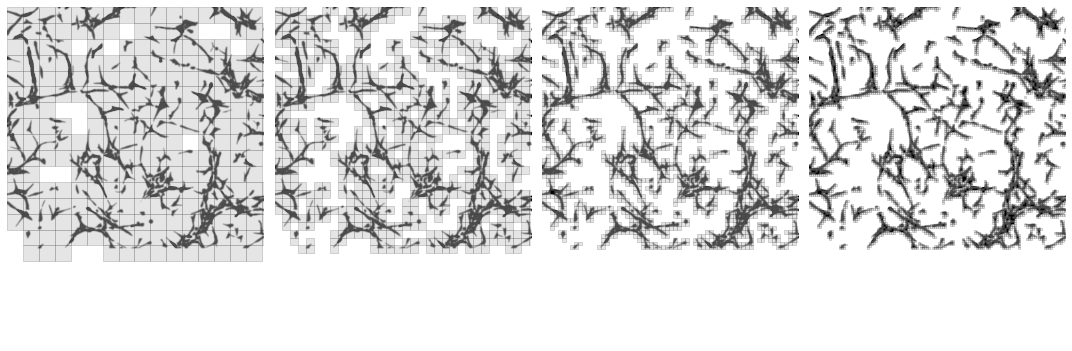

In [46]:

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    inst = read_instances('instances2232.data')
    Z = binarize_img(inst)
    ZZ = binarize_centroids(inst)
    
    print(fractal_dimension(Z, threshold=0.25))
    print(fractal_dimension(ZZ, threshold = 0.25))
    
    sizes = 128, 64, 32, 16  #, 8
    xmin, xmax = 0, Z.shape[1]
    ymin, ymax = 0, Z.shape[0]
    fig = plt.figure(figsize=(15, 10))

    for i, size in enumerate(sizes):
        ax = plt.subplot(1, len(sizes), i+1, frameon=False)
        ax.imshow(1-Z, plt.cm.gray, interpolation="bicubic", vmin=0, vmax=1,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")
        ax.set_xticks([])
        ax.set_yticks([])
        for y in range(Z.shape[0]//size+1):
            for x in range(Z.shape[1]//size+1):
                s = (Z[y*size:(y+1)*size, x*size:(x+1)*size] > 0.25).sum()
                if s > 0 and s < size*size:
                    rect = patches.Rectangle(
                        (x*size, Z.shape[0]-1-(y+1)*size),
                        width=size, height=size,
                        linewidth=.5, edgecolor='.25',
                        facecolor='.75', alpha=.4)
                    ax.add_patch(rect)

    plt.tight_layout()
    plt.savefig("fractal-dimension.png", dpi = 150)
    plt.show()